In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import seaborn as sns
import os

%matplotlib inline

In [3]:
calendar = pd.read_csv('./seattle/calendar.csv')
listings = pd.read_csv('./seattle/listings.csv')
reviews = pd.read_csv('./seattle/reviews.csv')

price_maps_path = './charts/maps/price'
vacancy_maps_path = './charts/maps/vacancy'

### Business Understanding

* The business is related to tourism activity, so it may be important to see what are the busiest period of the year and the best spots of the city for Airbnb owners.
* For this post I going to focus on the relationship between calendar dataset features with location and period of the year.
* I am going extract he location from the listings dataset

### DATA UNDERSTANDING


In [5]:
listings.keys()

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [4]:
listings.describe()

id     scrape_id       host_id  host_listings_count  \
count  3.818000e+03  3.818000e+03  3.818000e+03          3816.000000   
mean   5.550111e+06  2.016010e+13  1.578556e+07             7.157757   
std    2.962660e+06  0.000000e+00  1.458382e+07            28.628149   
min    3.335000e+03  2.016010e+13  4.193000e+03             1.000000   
25%    3.258256e+06  2.016010e+13  3.275204e+06             1.000000   
50%    6.118244e+06  2.016010e+13  1.055814e+07             1.000000   
75%    8.035127e+06  2.016010e+13  2.590309e+07             3.000000   
max    1.034016e+07  2.016010e+13  5.320861e+07           502.000000   

       host_total_listings_count     latitude    longitude  accommodates  \
count                3816.000000  3818.000000  3818.000000   3818.000000   
mean                    7.157757    47.628961  -122.333103      3.349398   
std                    28.628149     0.043052     0.031745      1.977599   
min                     1.000000    47.505088  -122.417219      1.000000   
25%                     1.000000    47.609418  -122.354320      2.000000   
50%                     1.000000    47.623601  -122.328874      3.000000   
75%                     3.000000    47.662694  -122.310800      4.000000   
max                   502.000000    47.733358  -122.240607     16.000000   

         bathrooms     bedrooms  ...  review_scores_rating  \
count  3802.000000  3812.000000  ...           3171.000000   
mean      1.259469     1.307712  ...             94.539262   
std       0.590369     0.883395  ...              6.606083   
min       0.000000     0.000000  ...             20.000000   
25%       1.000000     1.000000  ...             93.000000   
50%       1.000000     1.000000  ...             96.000000   
75%       1.000000     2.000000  ...             99.000000   
max       8.000000     7.000000  ...            100.000000   

       review_scores_accuracy  review_scores_cleanliness  \
count             3160.000000                3165.000000   
mean                 9.636392                   9.556398   
std                  0.698031                   0.797274   
min                  2.000000                   3.000000   
25%                  9.000000                   9.000000   
50%                 10.000000                  10.000000   
75%                 10.000000                  10.000000   
max                 10.000000                  10.000000   

       review_scores_checkin  review_scores_communication  \
count            3160.000000                  3167.000000   
mean                9.786709                     9.809599   
std                 0.595499                     0.568211   
min                 2.000000                     2.000000   
25%                10.000000                    10.000000   
50%                10.000000                    10.000000   
75%                10.000000                    10.000000   
max                10.000000                    10.000000   

       review_scores_location  review_scores_value  license  \
count             3163.000000          3162.000000      0.0   
mean                 9.608916             9.452245      NaN   
std                  0.629053             0.750259      NaN   
min                  4.000000             2.000000      NaN   
25%                  9.000000             9.000000      NaN   
50%                 10.000000            10.000000      NaN   
75%                 10.000000            10.000000      NaN   
max                 10.000000            10.000000      NaN   

       calculated_host_listings_count  reviews_per_month  
count                     3818.000000        3191.000000  
mean                         2.946307           2.078919  
std                          5.893029           1.822348  
min                          1.000000           0.020000  
25%                          1.000000           0.695000  
50%                          1.000000           1.540000  
75%                          2.000000           3.00

In [7]:
#verify the existence of missing values on listing dataset
listings[['id','latitude','longitude']].isnull().sum()

id           0
latitude     0
longitude    0
dtype: int64

In [8]:
calendar.keys()

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

In [10]:
#verify the existence of missing values on calendar dataset
calendar.isnull().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [12]:
#verify is all the listing ids have 365 dates
calendar['counter'] = 1
calendar[['listing_id','counter']].groupby('listing_id').sum().counter.unique()

array([365], dtype=int64)

### Data Preparation

Since there are no missing values, my focus will be to get the location from the listing dataframe, aggregate and merge the data so that I can plot the necessary maps and charts. In order to make this preparation I am going to use the GEOPANDAS package and the Seattle boundaries shapefile obtained from Seattle GeoData website. 


In [14]:
map = gpd.read_file('./seattle/Seattle_Neighborhoods/Seattle_Neighborhoods.shp')
map

OBJECTID_1  OBJECTID          AREA  PERIMETER  HOODS_  HOODS_ID  \
0             1         1  3.588443e+03    617.843       2         0   
1             2         2  2.229478e+04    733.568       3         0   
2             3         3  5.669537e+04   4088.442       5         0   
3             4         4  6.415681e+04   1809.446       6         0   
4             5         5  2.993164e+03    250.330       7         0   
5             6         6  1.137106e+04    408.586       8         0   
6             7         7  1.315780e+04    474.931       9         0   
7             8         8  2.664951e+03    197.126      10         0   
8             9         9  1.773268e+03    184.870      11         0   
9            10        10  1.190226e+05   1688.760      12         0   
10           11        11  2.609426e+03    239.993      13         0   
11           12        12  3.129215e+03    271.169      14         0   
12           13        13  6.258477e+03    434.345      15         0   
13           14        14  1.138620e+04    403.787      16         0   
14           15        15  1.698931e+04    666.719      17         0   
15           16        16  2.708875e+03    216.947      18         0   
16           17        17  7.245840e+02    143.478      19         0   
17           18        18  7.715780e+02    130.735      20         0   
18           19        19  1.462592e+06   6965.418      21         0   
19           20        20  1.804074e+05   2492.090      22         0   
20           21        21  3.248042e+03    286.629      23         0   
21           22        22  1.418240e+04    567.650      24         0   
22           23        23  1.894648e+04    577.787      25         0   
23           24        24  9.928967e+03    403.760      26         0   
24           25        25  3.556578e+04    730.198      27         0   
25           26        26  4.855840e+02     86.526      28         0   
26           27        27  2.132066e+07  18831.010      29       120   
27           28        28  2.243128e+07  27347.494      30       129   
28           29        29  1.419569e+07  15934.439      31       121   
29           30        30  2.219937e+07  21789.650      32       130   
..          ...       ...           ...        ...     ...       ...   
89           90        90  2.945466e+07  23549.932      92       174   
90           91        91  3.303827e+07  25917.117      93       180   
91           92        92  2.334301e+07  23180.396      94       182   
92           93        93  1.792332e+07  23416.340      95       190   
93           94        94  1.878106e+07  22360.047      96       191   
94           95        95  4.383528e+07  52212.785      97       173   
95           96        96  3.059971e+07  23840.219      98       117   
96           97        97  4.421636e+06  10013.274      99       143   
97           98        98  1.976319e+07  34138.930     100       146   
98           99        99  2.468095e+07  26230.434     101       147   
99          100       100  3.023924e+07  26851.947     102       151   
100         101       101  2.603959e+07  25522.346     103       149   
101         102       102  2.151273e+07  20753.002     104       106   
102         103       103  3.097739e+07  31987.734     105       107   
103         104       104  1.703485e+07  18770.281     106       108   
104         105       105  2.583674e+07  19993.816     107       104   
105         106       106  2.044149e+07  22788.760     108       105   
106         107       107  2.468199e+07  58047.309     109       198   
107         108       108  2.046117e+03    230.170     110         0   
108         109       109  5.813891e+05   3664.745     111         0   
109         110       110  4.811345e+07  34640.309     112       100   
110         111       111  2.769034e+07  26446.203     113       101   
111         112       112  4.720308e+07  29413.553     114       102   
112         113       113  2.943885e+07  2617

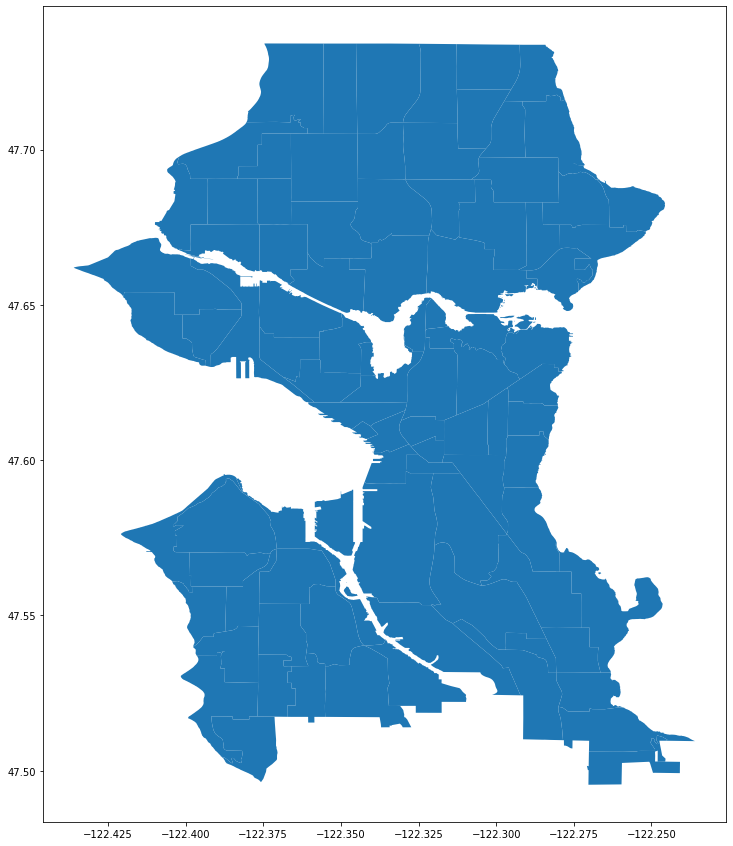

In [15]:
area_map = map[['geometry','AREA','OBJECTID_1']]
fig,ax = plt.subplots(figsize = (15,15))
area_map.plot(ax=ax);

In [16]:
geometry = [Point(xy) for xy in zip(listings['longitude'],listings['latitude'])]
crs = {'init':'epsg:4326'}

In [17]:
geo_listings = gpd.GeoDataFrame(listings, crs = crs, geometry = geometry )
geo_listings.head()

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview  ... requires_license  \
0                                                NaN  ...                f   
1  Queen Anne is a wonderful, truly functional vi...  ...                f   
2  Upper Queen Anne is a charming neighborhood fu...  ...                f   
3                                                NaN  ...                f   
4  We are in the beautiful neighborhood of Queen ...  ...                f   

  license jurisdiction_names instant_bookable cancellation_policy  \
0     NaN         WASHINGTON                f            moderate   
1     NaN         WASHINGTON                f              strict   
2     NaN         WASHINGTON                f              strict   
3     NaN         WASHINGTON                f            flexible   
4     NaN         WASHINGTON                f              strict   

  require_guest_profile_picture  require_guest_phone_verification  \
0                             f                                 f   
1                             t                                 t   
2                             f                                 f   
3                             f                                 f   
4                             f                                 f   

  calculated_host_listings_count reviews_per_month  \
0                              2              4.07   
1                              6              1.48   
2                              2              1.15   
3                              1               NaN   
4                              1              0.89   

                                       geometry  
0  POINT (-122.3710251999777 47.63628903835718)  
1  POINT (-122.3656664643958 47.63912312136253)  
2  POINT (-122.3694831756176 47.62972413157735)  
3  POINT (-122.3692791226302 47.63847320176642)  
4  POINT (-122.3724706340222 47.63291840276724)  

[5 rows x 93 columns]

In [18]:
airbnb_within_area = gpd.sjoin(geo_listings, area_map, how="inner", op='intersects')
#To work whith numbers I had to tranform some strings featurings such as 'price' into float.
airbnb_within_area['price'] = airbnb_within_area['price'].apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',','')).astype(np.float64)


### Evalution and Deployment

### agg_feat_by_area

Here I going to plot the charts and maps that need to reach my conclusions. 
Firstly i made a function "agg_feat_by_area" to plot any color map with the values of a choosen featuring aggregated by neighbothood. Since my interest was to get the number of people that each neighborhood could accomodate, I used this function to plot a color map with the accomodtion capacity of each neighborhood.

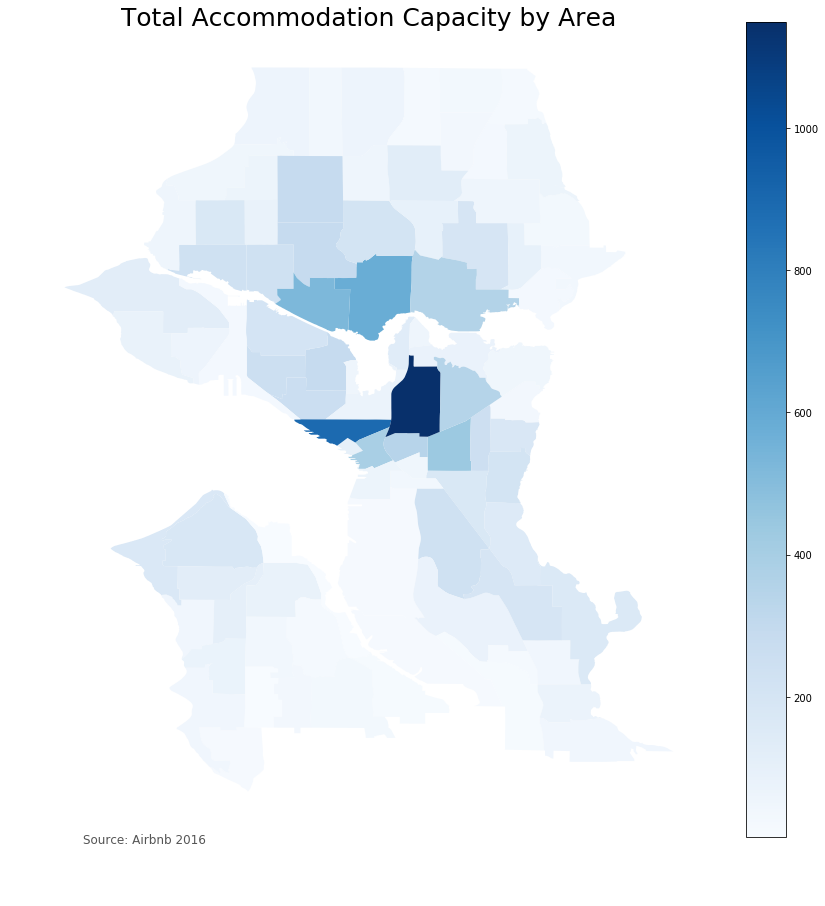

In [10]:
def agg_feat_by_area(df_map, df_feat, feat, colormap, title, agg_type = 'sum'):
    '''
    df_map = boundaries shapefile dataframe 
    df_feat = featuring dataframe, it must include geometry column
    colormap = color of the colormap
    title = figure tittle
    agg_type = data aggregation type
    
    Returns the merged dataframe with the aggregate values and their geometry and object_id.
    Plots a colormap of the merged dataframe.
    '''
    
    
    if agg_type == 'sum':
        feat_within_area = df_feat[['OBJECTID_1',feat]].groupby('OBJECTID_1', as_index = False).sum()
    if agg_type == 'mean':
        feat_within_area = df_feat[['OBJECTID_1',feat]].groupby('OBJECTID_1', as_index = False).mean()   
        
    feat_map = pd.merge(df_map, feat_within_area, on = 'OBJECTID_1', how = 'inner')
        
    fig,ax = plt.subplots(figsize = (15,15))
    
    feat_map.plot(ax = ax, column = feat, cmap = colormap);
    
    ax.axis('off')
    
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
    
    ax.annotate('Source: Airbnb 2016',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
    
    vmin, vmax = feat_map[feat].min(), feat_map[feat].max()
    
    sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(vmin=vmin, vmax=vmax))
    
    cbar = fig.colorbar(sm)
    
    return feat_map
    
accommodates_map = agg_feat_by_area(area_map,airbnb_within_area,'accommodates','Blues', 'Total Accommodation Capacity by Area', 'sum')

### feat_per_area_plot
In order to make a chart of price and availability values druing the year for a particular neighborhood or the entire city I made the "feat_per_area_plot" function.

In [19]:
calendar_geo = pd.merge(calendar, airbnb_within_area[['id','OBJECTID_1','geometry']], left_on = 'listing_id', right_on ='id',how = 'inner')
calendar_geo['price'] = calendar_geo['price'].apply(lambda x: str(x)).apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',','')).astype(np.float64)
calendar_geo['available'] = calendar_geo['available'].replace({'t':1,'f':0})
calendar_geo['date'] = pd.to_datetime(calendar_geo['date'], format = '%Y-%m-%d')


def feat_per_area_plot(object_id = None):
    '''
    object_id = id of the neighborhood. If it not specified, the object will be the entire city.
    
    It plots the map of the object next to a chart with the average price and vacancy rate during the year.
    '''
    
    if object_id:
        calendar_geo_area = calendar_geo[calendar_geo.OBJECTID_1 == object_id]
    else:
        calendar_geo_area = calendar_geo
        
    calendar_geo_area_available = calendar_geo_area[calendar_geo_area.available == 1]
    calendar_geo_area_mean_price_per_month = calendar_geo_area_available[['date','price']].set_index('date').groupby(pd.Grouper(freq='M')).mean()
    
    
    calendar_geo_area_vacancy_per_month = calendar_geo_area[['date','available']].set_index('date').groupby(pd.Grouper(freq='M')).mean()
    
    line_weight = 3
    alpha = .5
    
    fig, (ax0,ax1) = plt.subplots(1, 2,figsize=(10, 4))
    if object_id:
        fig_map = map[map.OBJECTID_1 == object_id].plot(ax=ax0);
    else:
        fig_map = map.plot(ax=ax0)
    fig_map.axis('off')
    ax2 = ax1.twinx()
    lns1 = ax1.plot(calendar_geo_area_mean_price_per_month, color='blue', lw=line_weight, alpha=alpha, label='Average Price')
    lns2 = ax2.plot(calendar_geo_area_vacancy_per_month, color='orange', lw=line_weight, alpha=alpha, label='Vacancy Rate')
    leg = lns1 + lns2;
    
    labs = [l.get_label() for l in leg]
    ax1.legend(leg, labs, loc=0)
    ax1.set_xticks(calendar_geo_area_vacancy_per_month.index)
    ax1.set_xticklabels( ['jan/16','feb/16','mar/16','apr/16','may/16','jun/16','jul/16','ago/16','sep/16','oct/16','nov/16','dec/16','jan/17'], rotation=75 ) 
    ax1.set_ylabel('Average Price')
    ax2.set_ylabel('Vacancy Rate')
    
    plt.show()
    


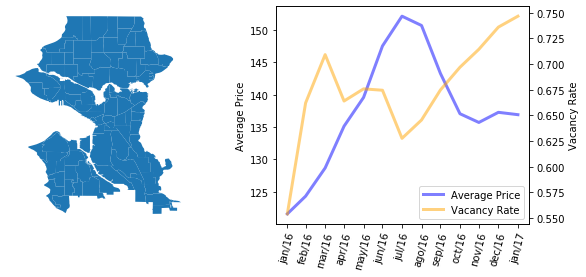

In [21]:
feat_per_area_plot()

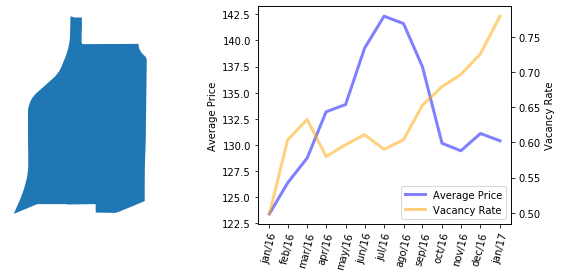

In [22]:
feat_per_area_plot(100)

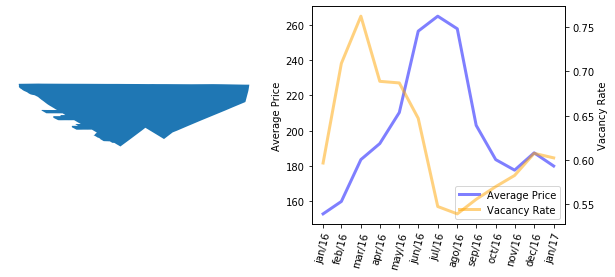

In [23]:
feat_per_area_plot(60)

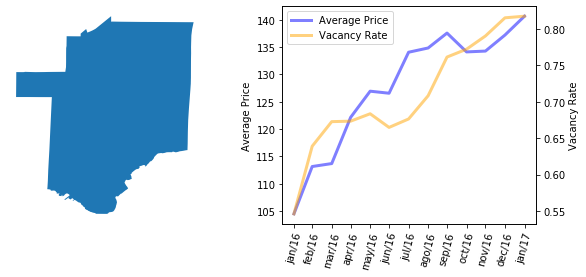

In [24]:
feat_per_area_plot(32)

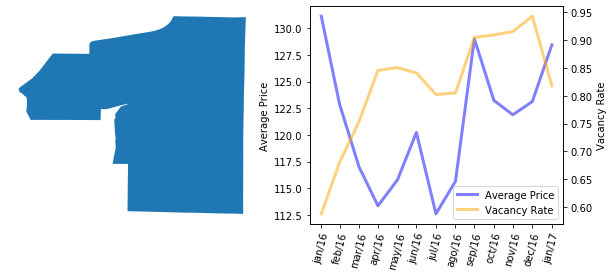

In [25]:
feat_per_area_plot(72)

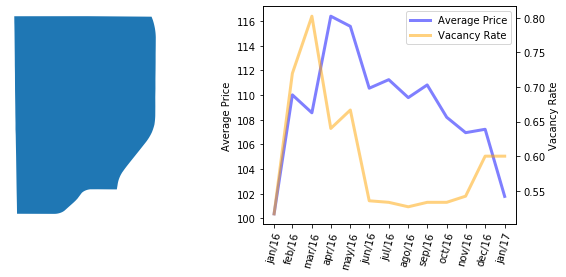

In [26]:
feat_per_area_plot(112)

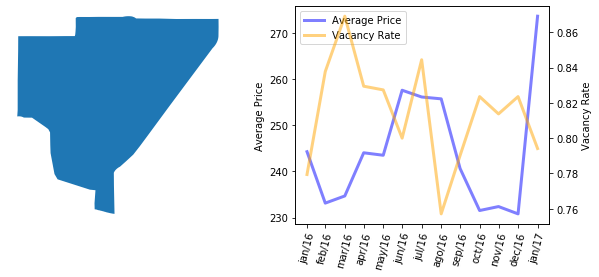

In [27]:
feat_per_area_plot(52)

### save_gif_images

This function will save the color maps that I need to make the GIFs that intend to use as tool to visualize the price and vacancy by location and time of the year.
To use this function we will need to have the dataframe properly aggregated to each one of the features. For the price I only needed the dates that were available, beacuse those were the ones that had price. For the availability I aggreagated the whole dataframe in order to have the percentage of dates that were available.

In [31]:
calendar_geo_price = calendar_geo[calendar_geo.available == 1].copy()
calendar_geo_price['month_year'] =  calendar_geo_area['date'].apply(lambda r: r.strftime('%Y-%m'))

In [39]:
calendar_geo_available = calendar_geo.copy()
calendar_geo_available['month_year'] = calendar_geo_vac['date'].apply(lambda r: r.strftime('%Y-%m'))
calendar_geo_available = calendar_geo_vac.dropna(subset = ['date'],axis = 0, how= 'any')

In [34]:
def save_gif_images(calendar_geo, feat, colormap, title, vmin, vmax, maps_path):
    '''
    calendar_geo = The dataframe choosen. It must be 'calendar_geo_price' or 'calendar_geo_available'.
    feat = the featuring choosen. It must be 'price' or 'available'.
    colormap = color of the colormap
    title = figure title
    vmin = minimum value
    vmax = maximum value
    maps_path = folder path
    
    It saves the gif's colormaps into a folder
    
    '''
    month_year = calendar_geo['month_year'].unique()
    for my in month_year:
        calendar_geo_by_month = calendar_geo[calendar_geo.month_year == my]
        calendar_geo_area_agg = calendar_geo_by_month[['OBJECTID_1',feat]].groupby('OBJECTID_1', as_index=False).mean()
        calendar_geo_area_agg =  pd.merge(map,calendar_geo_area_agg, on = 'OBJECTID_1',how = 'inner')

        fig,ax = plt.subplots(figsize = (15,15));
        sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(vmin = vmin, vmax = vmax))
        cbar = fig.colorbar(sm)
        fig  = calendar_geo_area_agg.plot(ax = ax, column = feat, cmap = colormap, \
                                             figsize=(10,10), linewidth=0.8, edgecolor='0.8', \
                                             vmin = vmin, vmax = vmax, norm=plt.Normalize(vmin = vmin, vmax = vmax));

        ax.annotate('Source: Airbnb 2016',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

        fig.axis('off')
        fig.set_title(title, \
                      fontdict={'fontsize': '25','fontweight' : '3'})

        fig.annotate(my,xy=(0.075, .5), xycoords='figure fraction',horizontalalignment='left', verticalalignment='top',fontsize=25);

        filepath = os.path.join(maps_path, my + '_'+ feat +'jpg')
        chart = fig.get_figure()
        chart.savefig(filepath, dpi=300)

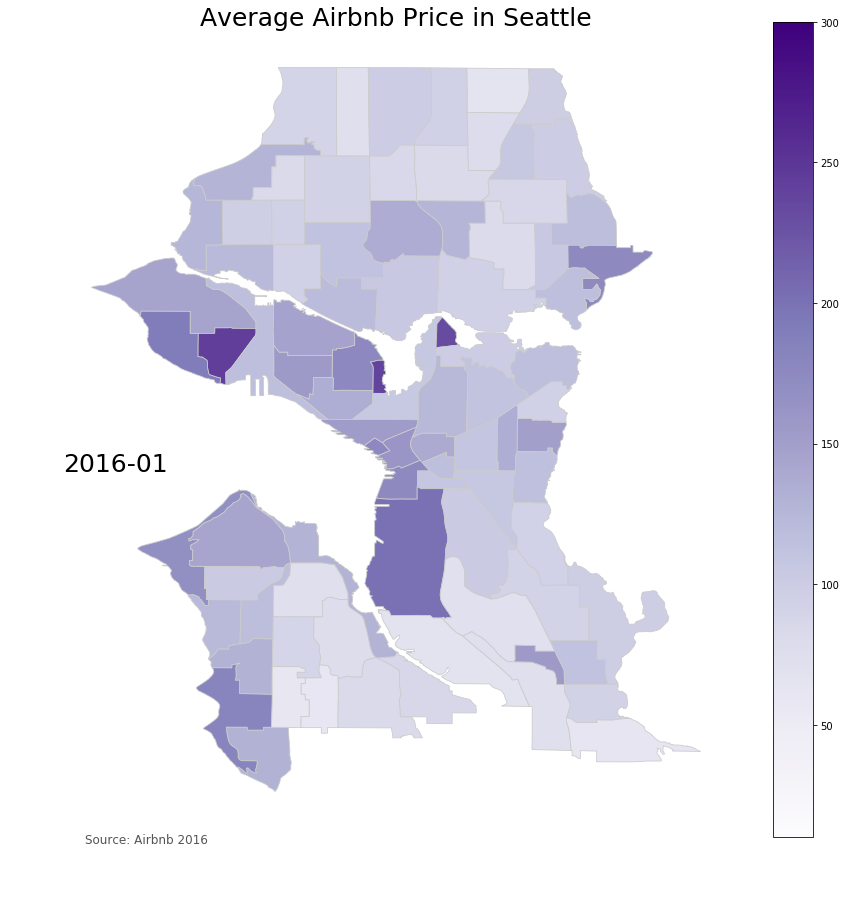

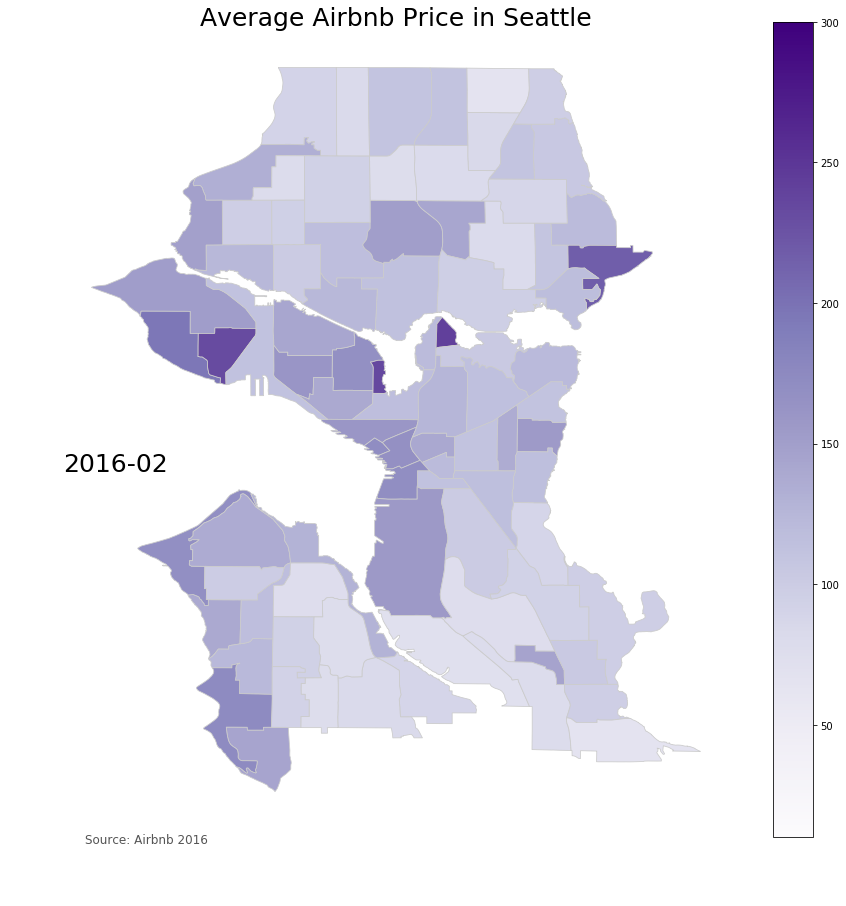

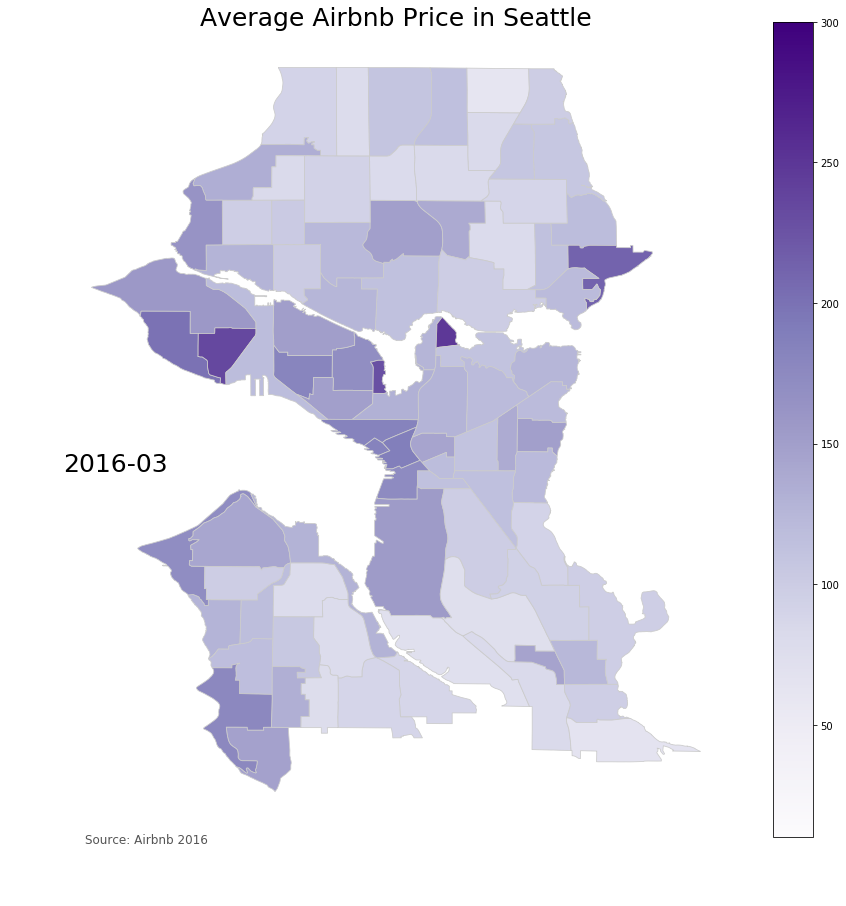

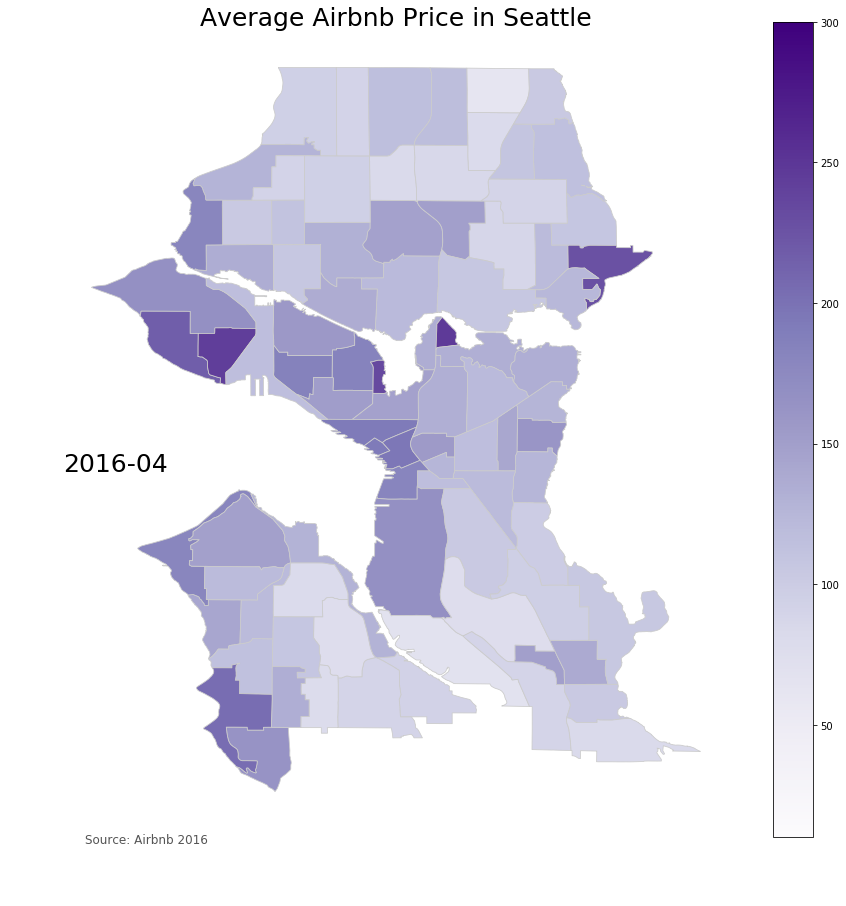

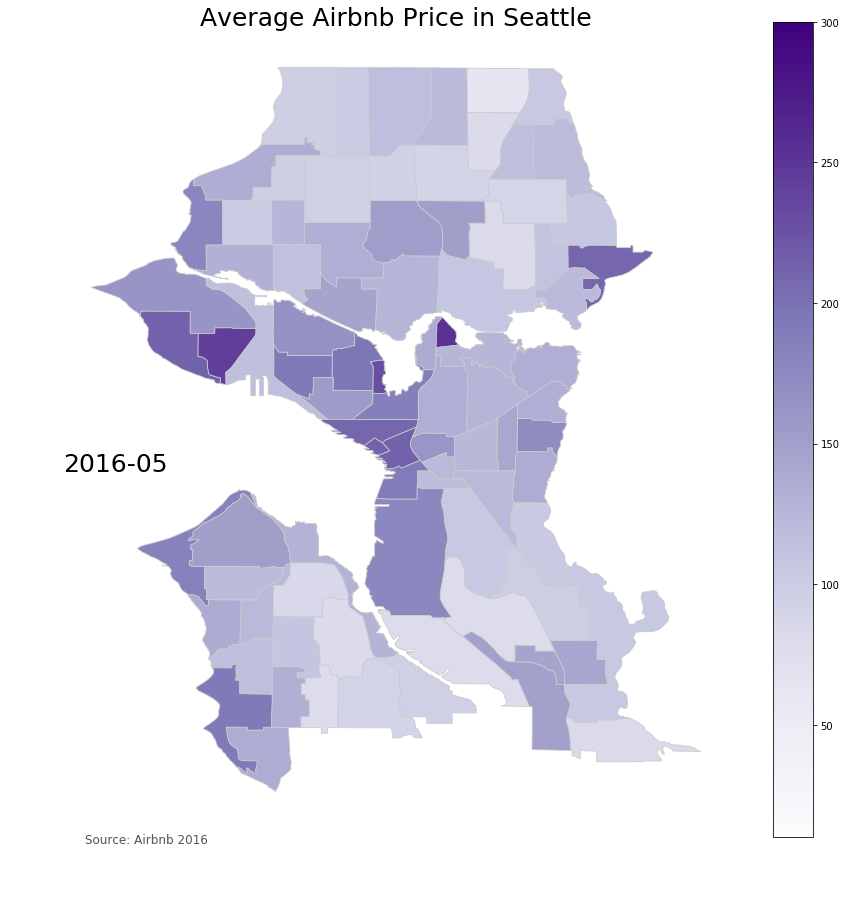

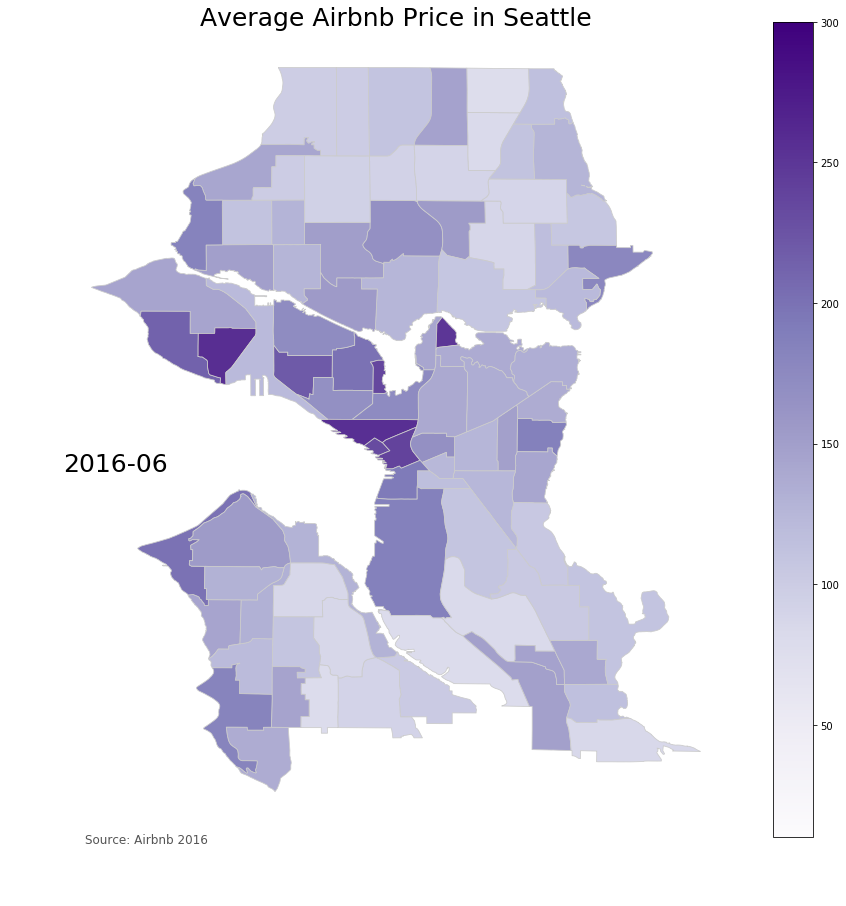

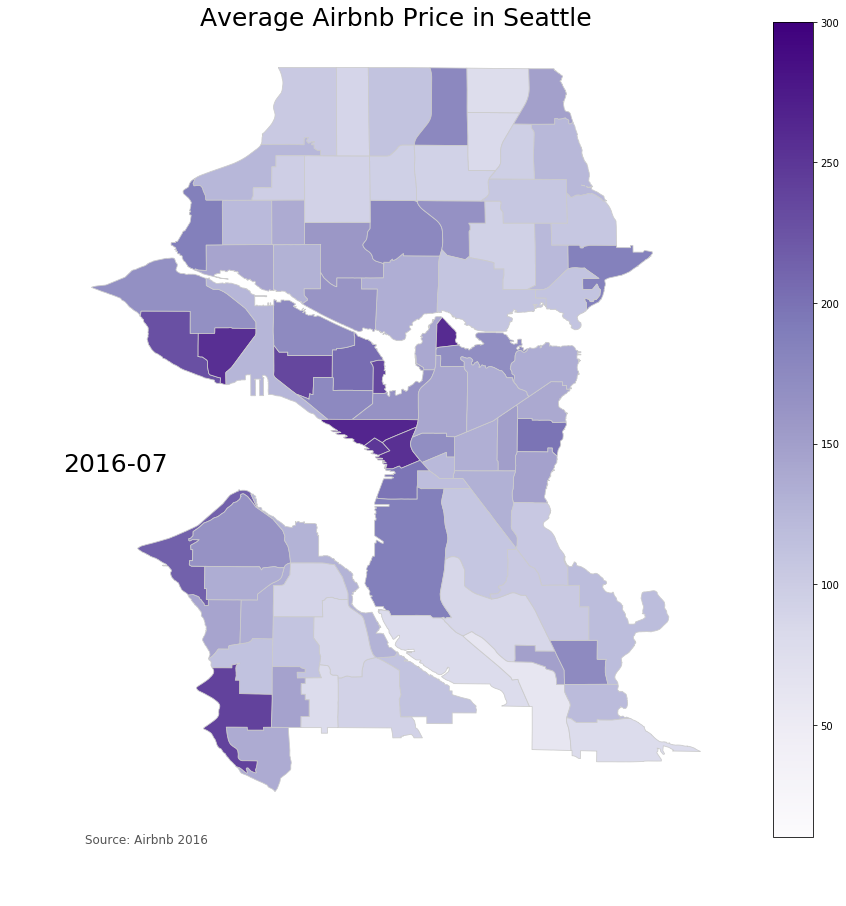

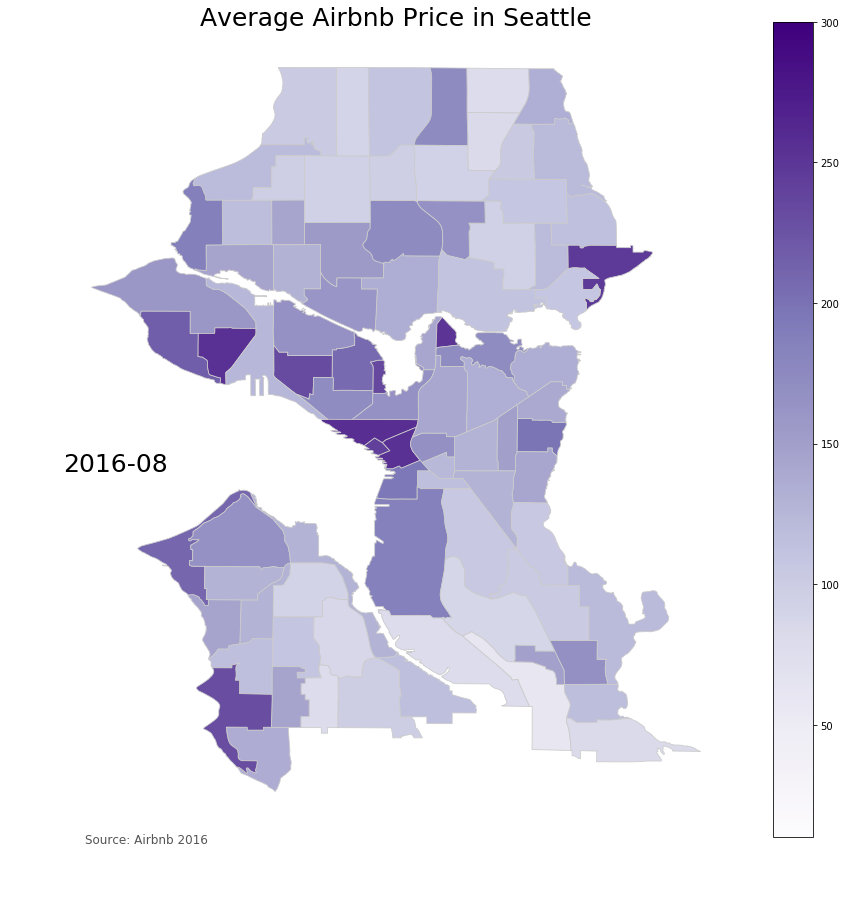

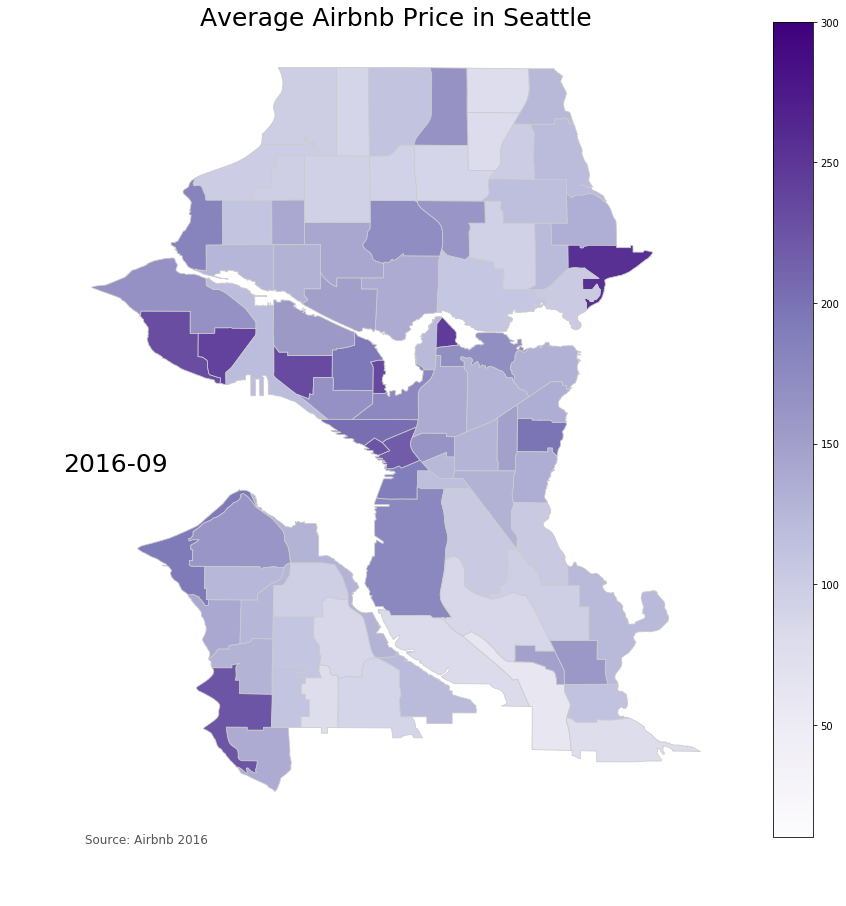

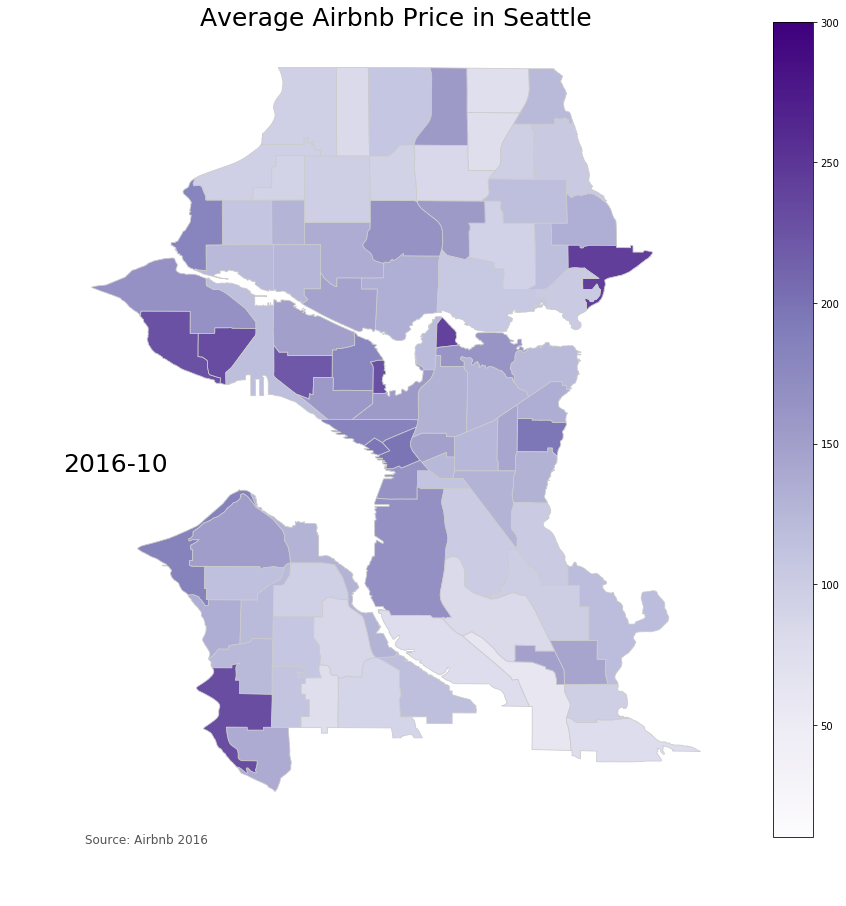

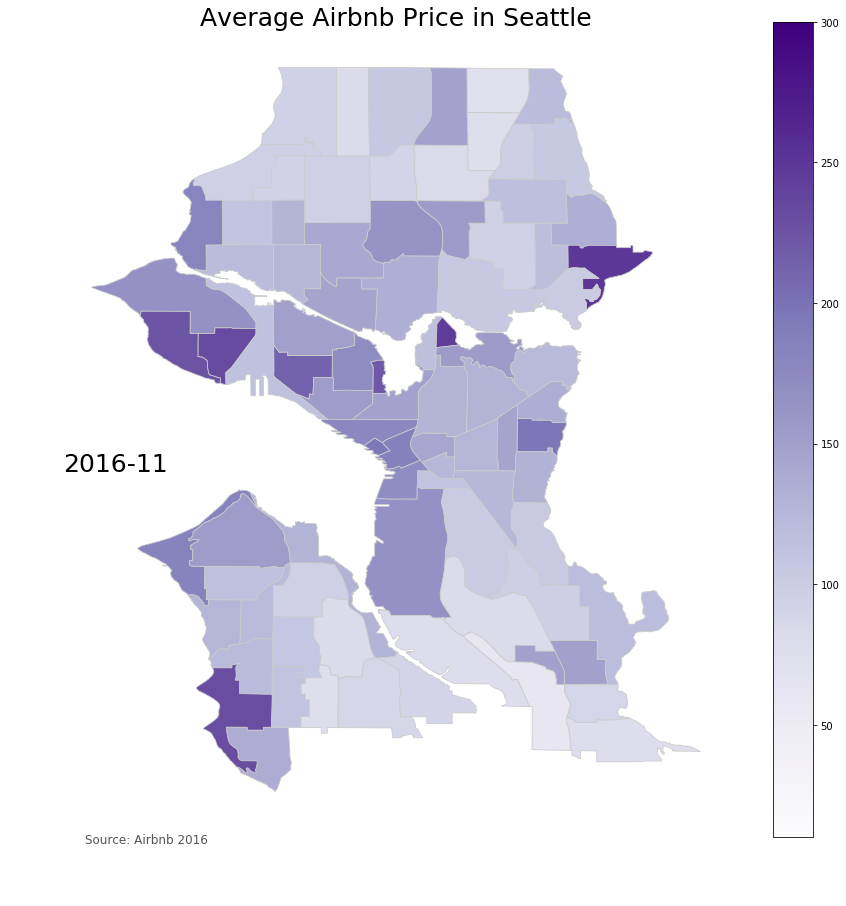

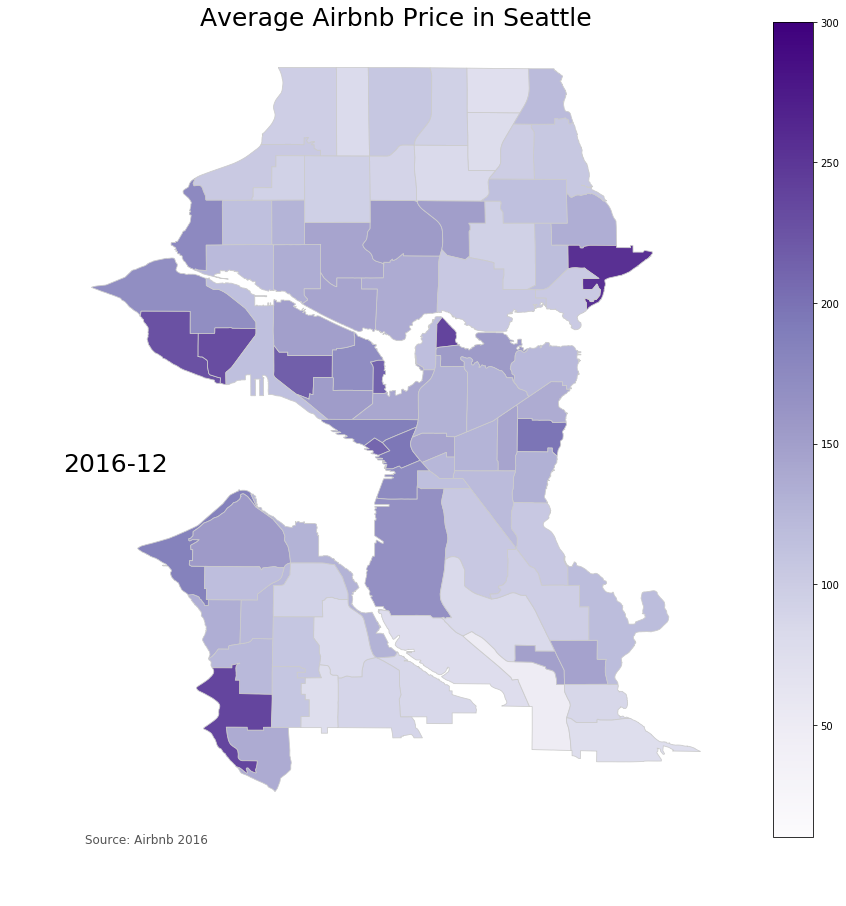

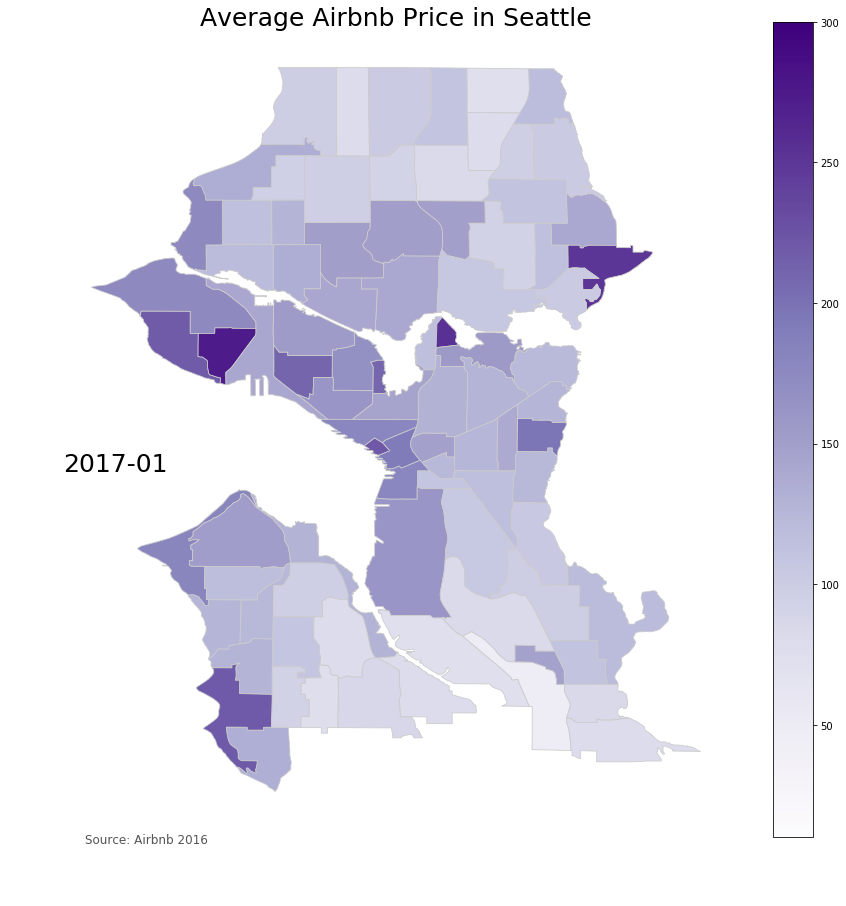

In [35]:
save_gif_images(calendar_geo_price,'price','Purples','Average Airbnb Price in Seattle', 10 , 300, price_maps_path)

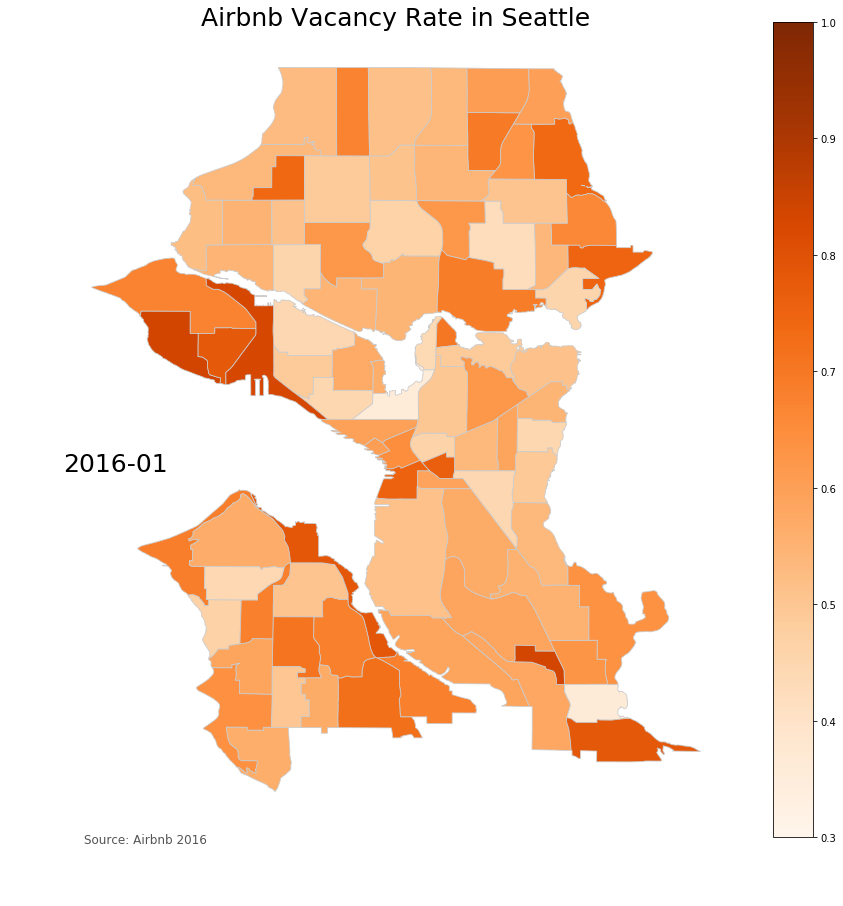

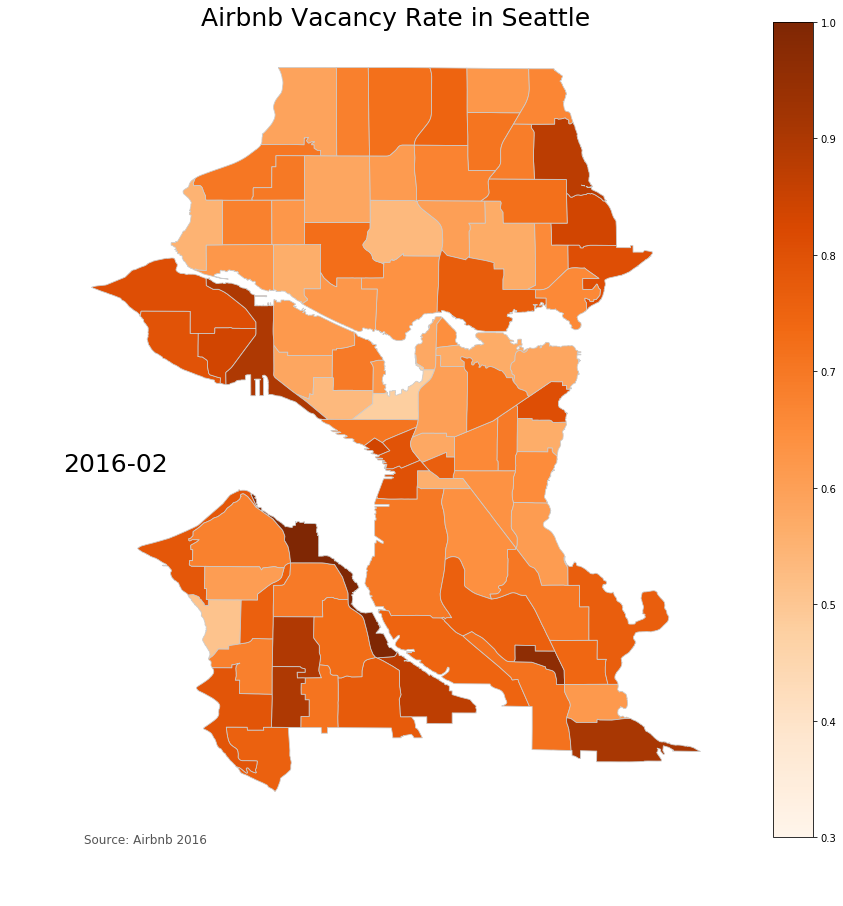

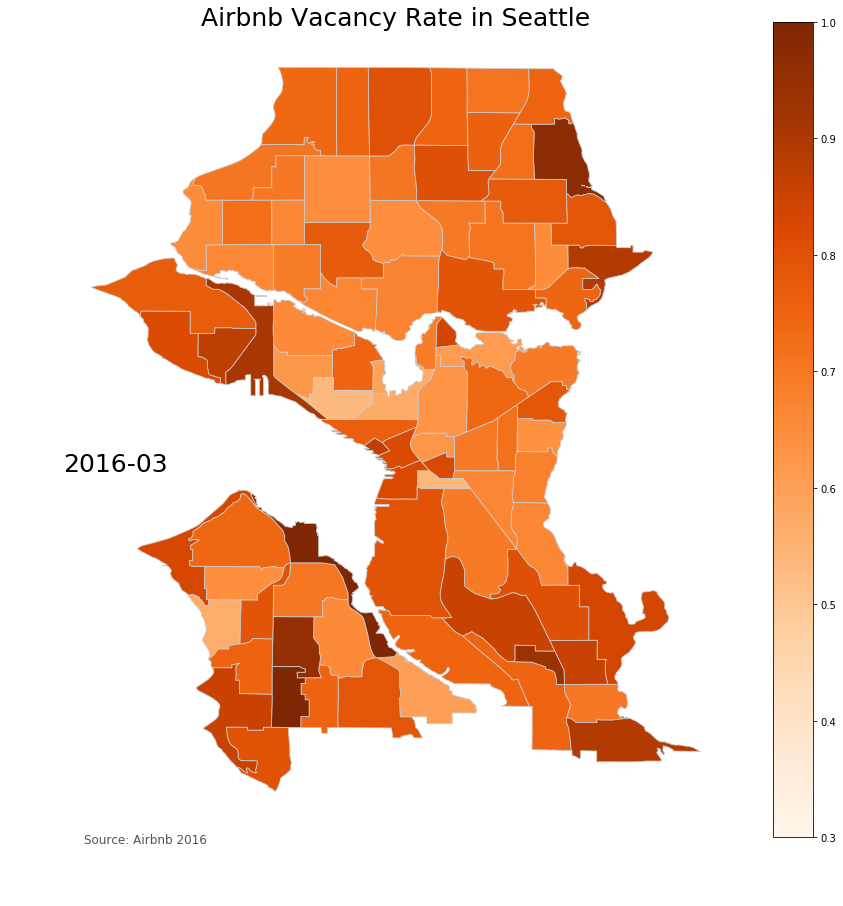

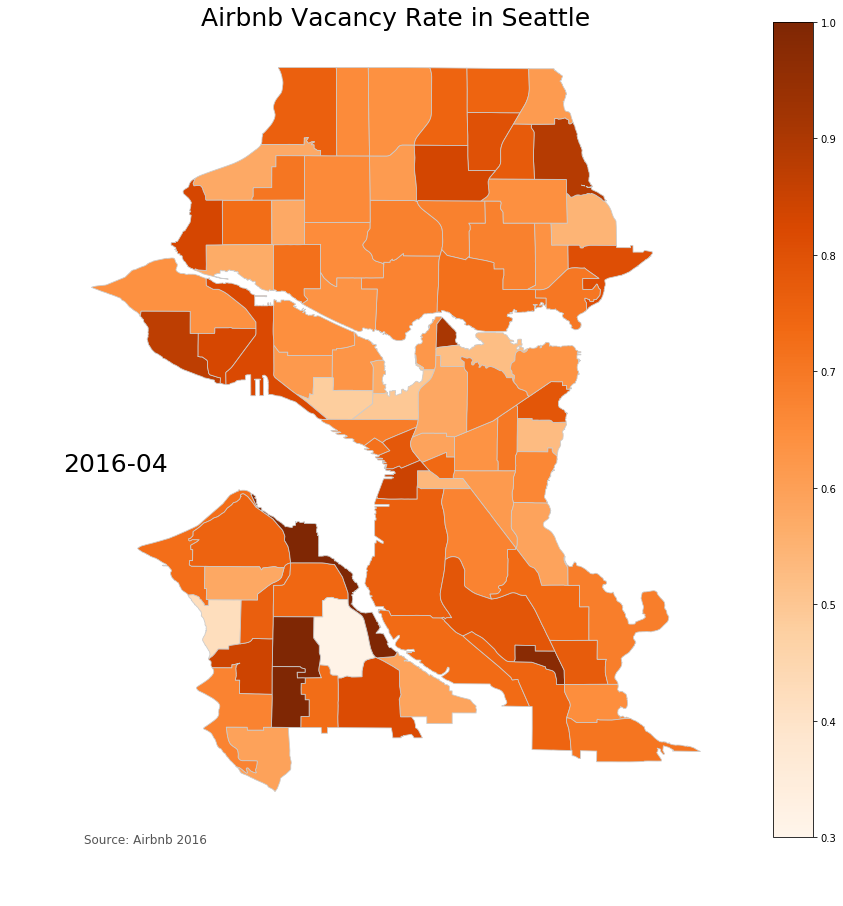

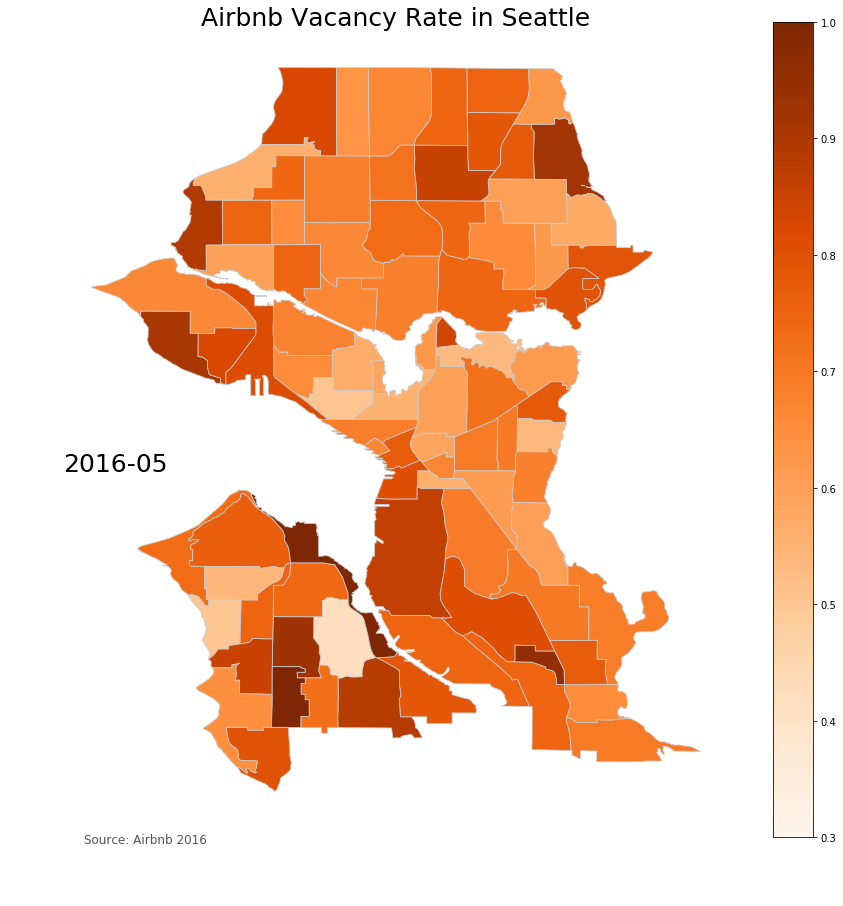

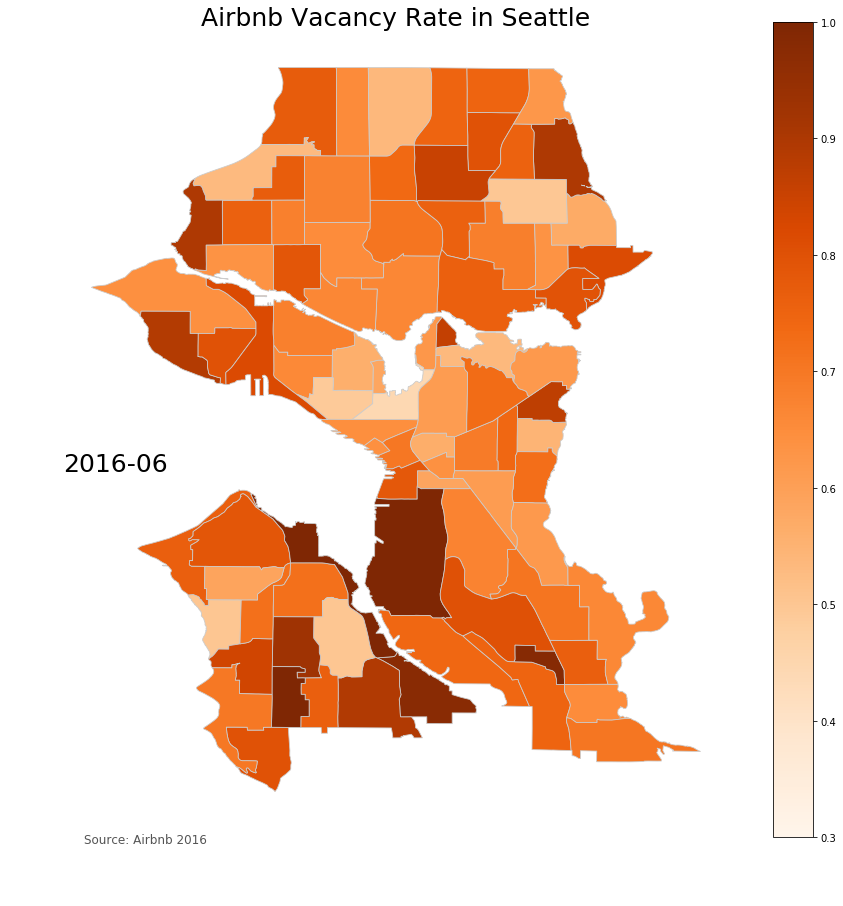

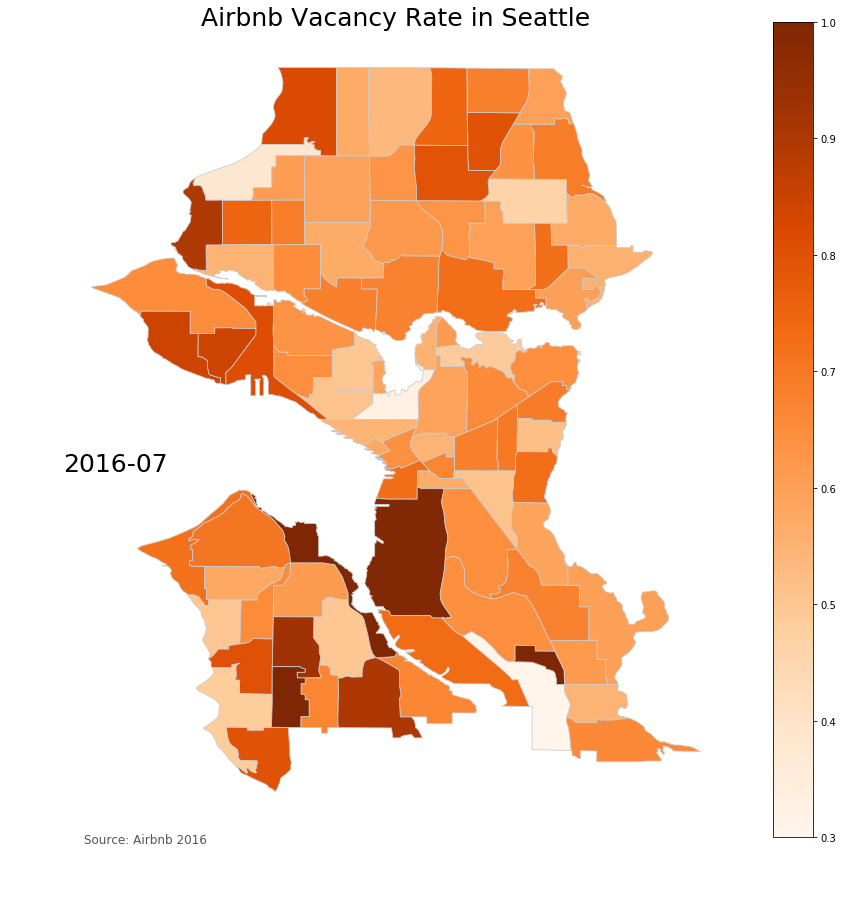

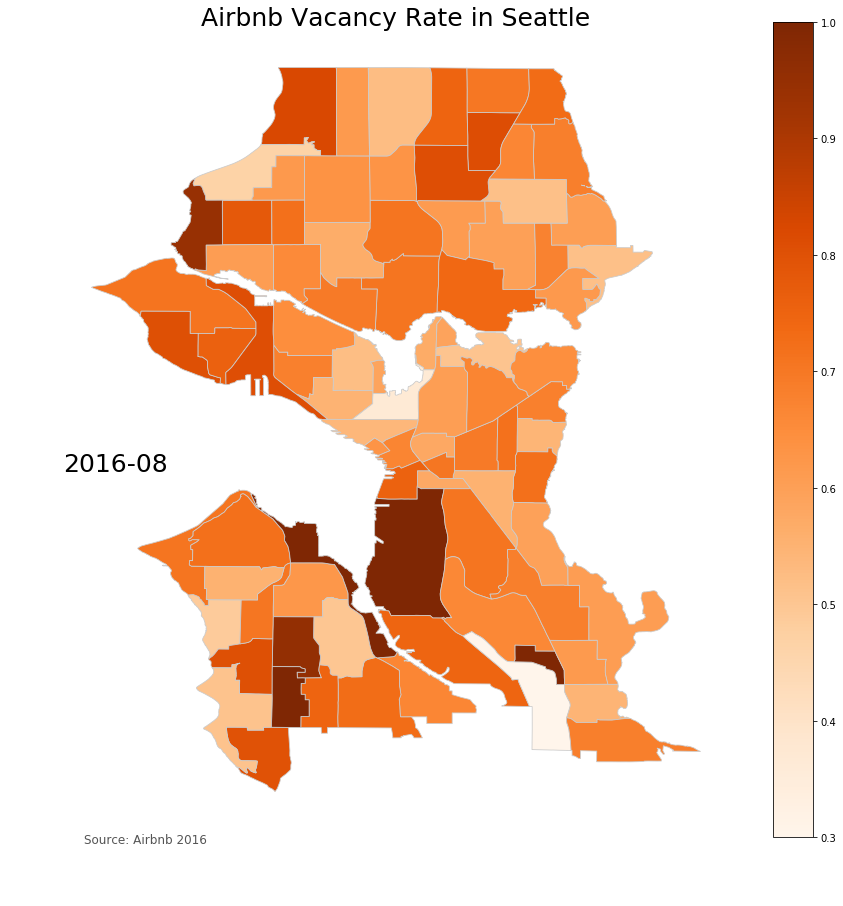

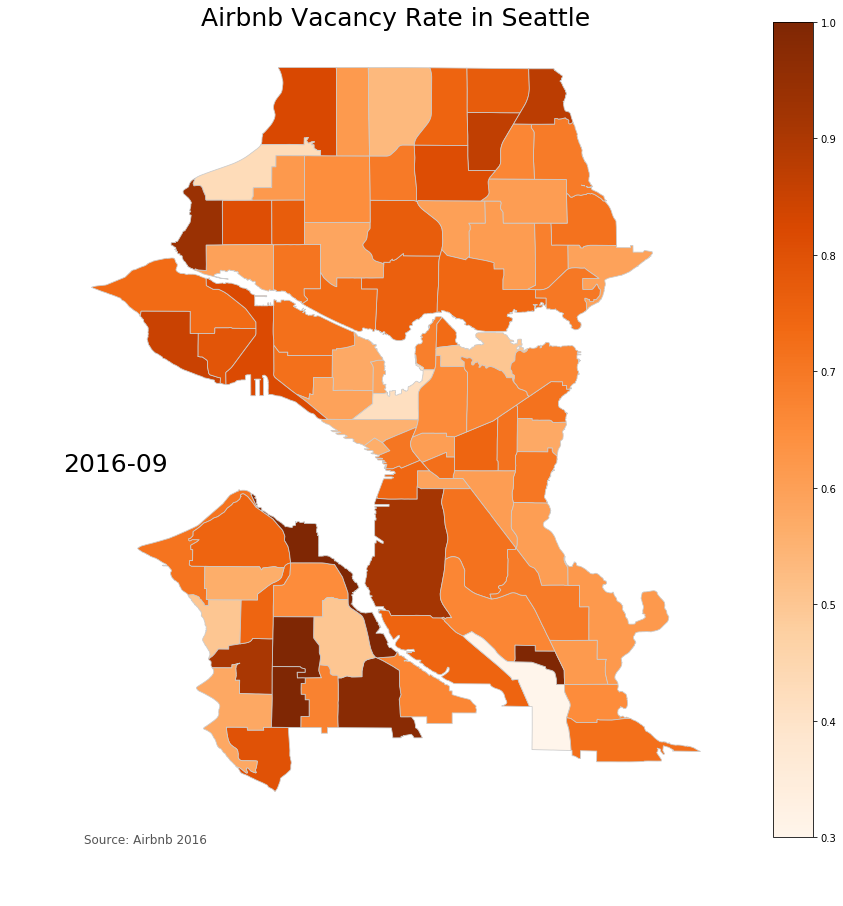

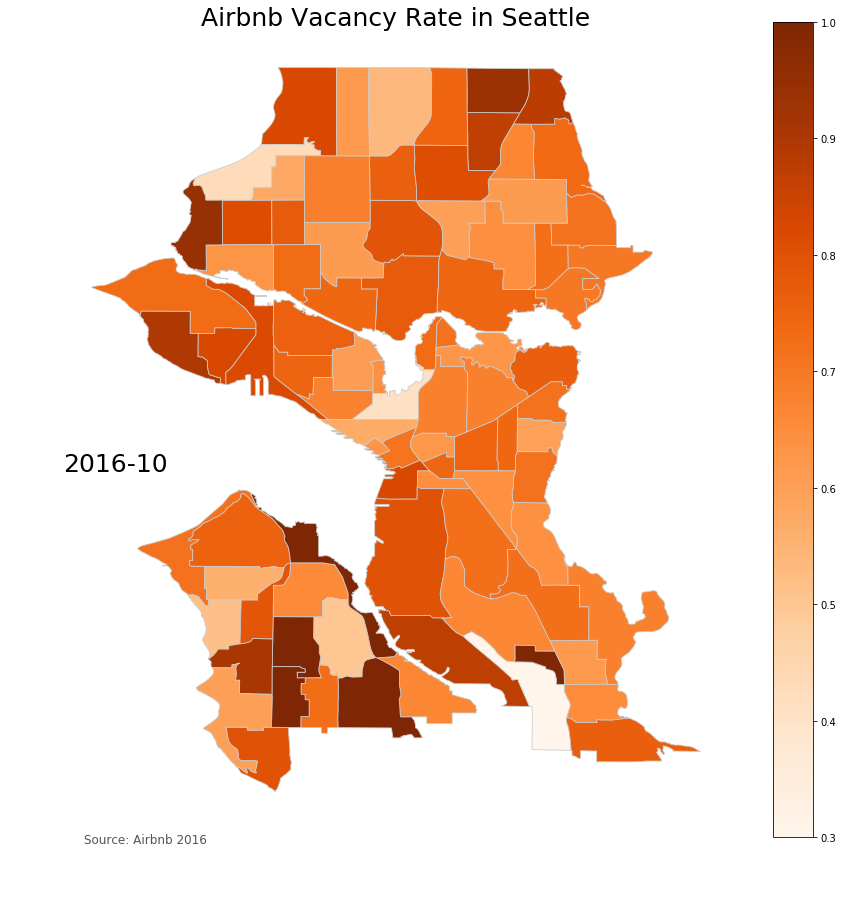

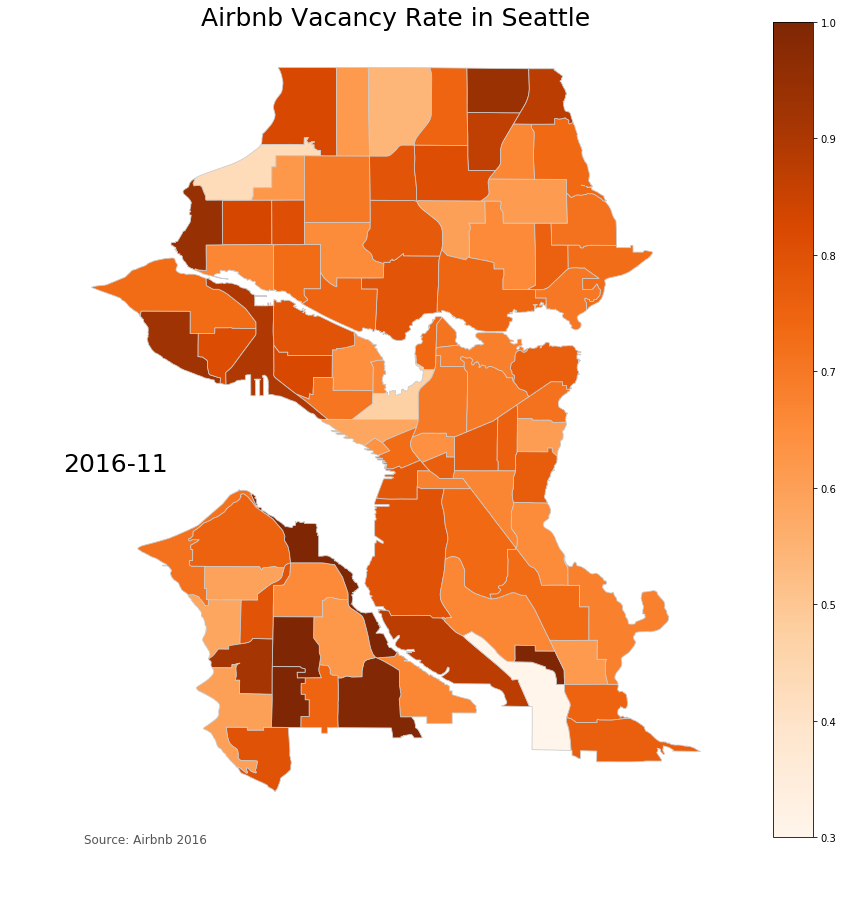

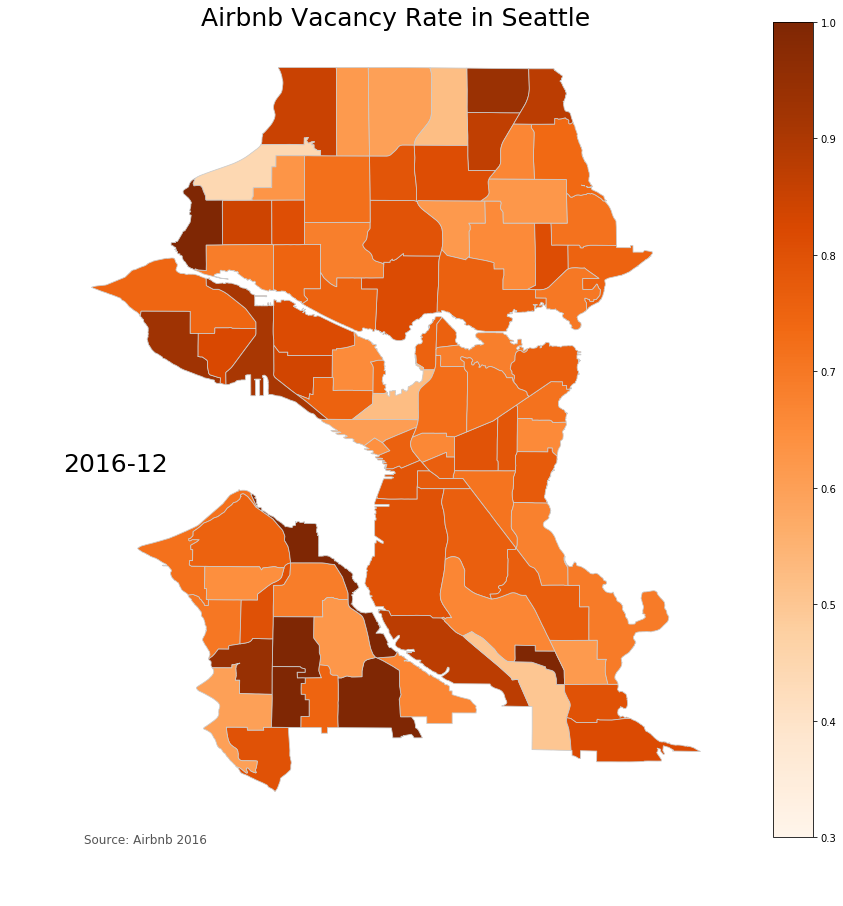

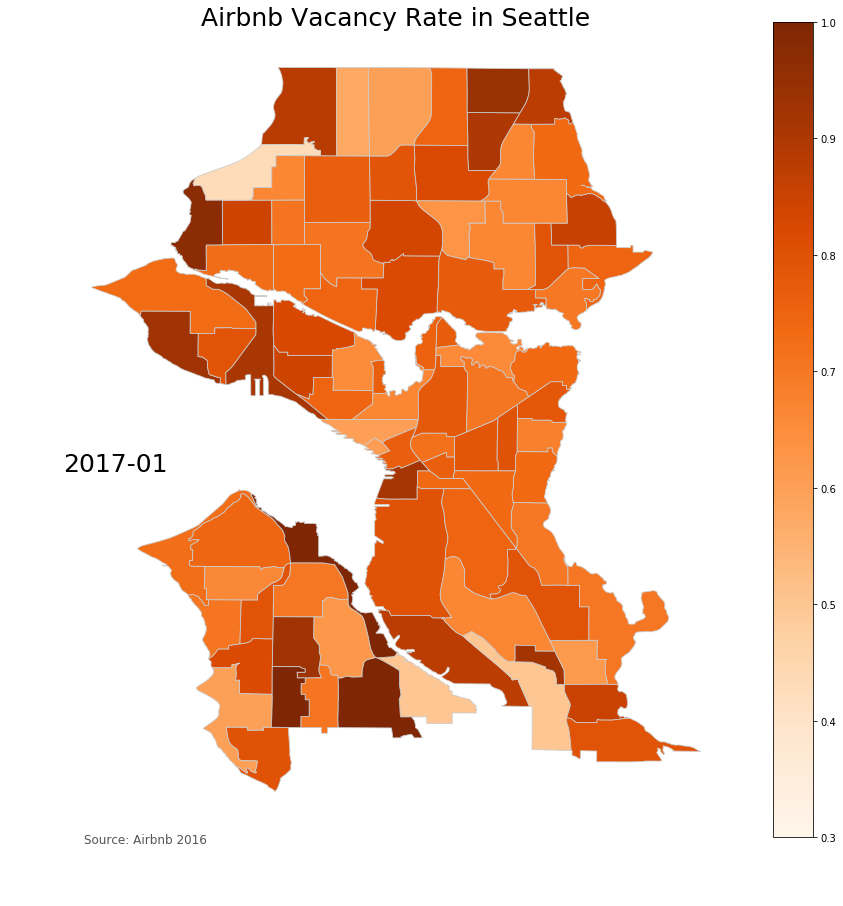

In [40]:
save_gif_images(calendar_geo_available,'available','Oranges','Airbnb Availability Rate in Seattle', 0.3 , 1, vacancy_maps_path)